<a href="https://colab.research.google.com/github/hahdawg/gbmclass/blob/master/rossmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q lightgbm

In [0]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

In [0]:
def load_data():
  res = pd.read_csv("https://github.com/hahdawg/gbmclass/raw/master/rossmann.csv")
  res["date"] = pd.to_datetime(res["date"], format="%Y-%m-%d")
  res = res.loc[res["date"] >= "1/1/2014"]
  
  holiday_dummies = pd.get_dummies(res["stateholiday"])
  holiday_dummies = holiday_dummies*np.arange(1, holiday_dummies.shape[1] + 1)
  holiday_dummies = holiday_dummies.max(axis=1) - 1
  res["stateholiday"] = holiday_dummies
  return res

In [0]:
def compute_model_data(data):
  columns = ["sales", "open", "promo", "stateholiday", "schoolholiday"]
  pivot = pd.pivot_table(data, index="store", columns="date").fillna(0)
  res = {c: pivot[c] for c in columns}
  res["sales"] = np.log1p(res["sales"])
  return res

In [0]:
data = load_data()
model_data = compute_model_data(data)

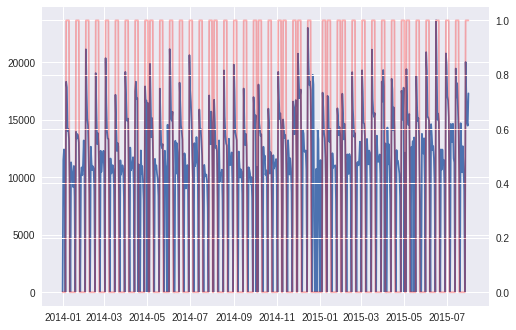

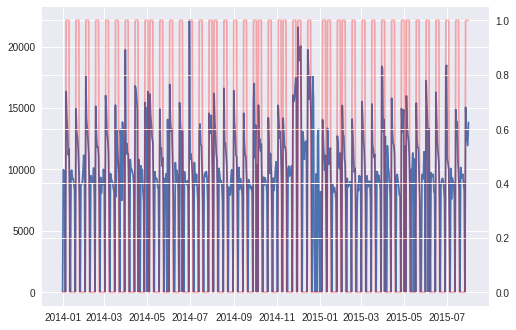

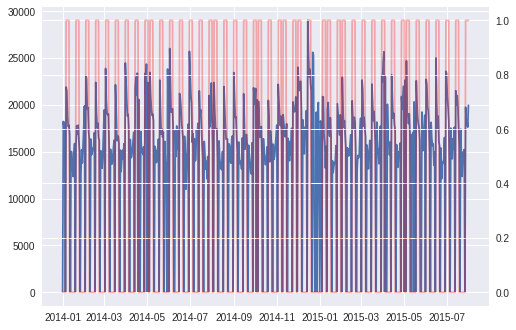

In [12]:
random_store_idxs = [12, 36, 43]
for i in random_store_idxs:
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(model_data["sales"].columns, np.expm1(model_data["sales"].iloc[i, :]))
  ax2 = ax.twinx()
  ax2.plot(model_data["promo"].columns, model_data["promo"].iloc[i, :], c="r", alpha=0.3)

In [0]:
def compute_timespan(df, test_date, offset, num_periods, freq="D"):
    end_date = pd.to_datetime(test_date)
    start_date = end_date - pd.tseries.offsets.Day(offset)
    cols = pd.date_range(start=start_date, periods=num_periods, freq=freq)
    return df.loc[:, cols]

In [0]:
def compute_test_date_features(test_date, model_data):
  
  #########################################################
  #TODO: Add Features
  test_date = pd.to_datetime(test_date)
  X = dict()
  window_days = 56

  ts_sales = compute_timespan(
      model_data["sales"],
      test_date=test_date,
      offset=window_days,
      num_periods=window_days
  )

  X["sales-mean-window-{}".format(window_days)] = ts_sales.mean(axis=1)
  X["sales-median-window-{}".format(window_days)] = ts_sales.median(axis=1)
  X["sales-std-window-{}".format(window_days)] = ts_sales.std(axis=1)

  for c in ("promo", "stateholiday", "schoolholiday"):
    X[c] = model_data[c][test_date].values
    
  X["store"] = model_data["sales"].index.values

  X = pd.DataFrame(X)
  #########################################################
  y = model_data["sales"][test_date]
  weight = model_data["open"][test_date]
  
  return X, y, weight


In [0]:
TRAIN_DATES = pd.date_range("6/1/2014", "3/31/2015")
VALID_DATES = pd.date_range("4/1/2015", "6/1/2015")


def compute_features(dates, model_data):
  res = [compute_test_date_features(d, model_data) for d in dates]
  res = list(zip(*res))
  res = [pd.concat(xs, axis=0) for xs in res]
  return res


def compute_train_features(model_data):
  return compute_features(TRAIN_DATES, model_data)


def compute_valid_features(model_data):
  return compute_features(VALID_DATES, model_data)

In [0]:
def fit_gbm_model(X_train, y_train, wt_train, X_valid, y_valid, wt_valid):
  fixed_params = dict(
    objective="mae",
    metric="mae"
  )
  
  #########################################################
  #TODO: Adjust hyperparams
  hyperparams = dict(
    learning_rate=0.3,
    min_data_in_leaf=1,
    num_leaves=2,
    bagging_fraction=1.0,
    feature_fraction=1.0
  )
  #########################################################
  
  params = dict(list(fixed_params.items()) + list(hyperparams.items()))
  
  dtrain = lgb.Dataset(X_train, y_train, weight=wt_train)
  dvalid = lgb.Dataset(X_valid, y_valid, weight=wt_valid)
  
  gbm = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=5000,
    valid_sets=(dtrain, dvalid),
    early_stopping_rounds=200,
    verbose_eval=50,
    categorical_feature=["store"]
  )
  return gbm

# Calculate design matrices.

In [0]:
X_train, y_train, wt_train = compute_train_features(model_data)
X_valid, y_valid, wt_valid = compute_valid_features(model_data)

# Fit the Model

In [18]:
model = fit_gbm_model(X_train, y_train, wt_train, X_valid, y_valid, wt_valid)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['store']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 0.139927	valid_1's l1: 0.149713
[100]	training's l1: 0.139217	valid_1's l1: 0.150237
[150]	training's l1: 0.138984	valid_1's l1: 0.150408
[200]	training's l1: 0.13885	valid_1's l1: 0.150417
[250]	training's l1: 0.138742	valid_1's l1: 0.150427
Early stopping, best iteration is:
[51]	training's l1: 0.1399	valid_1's l1: 0.149556


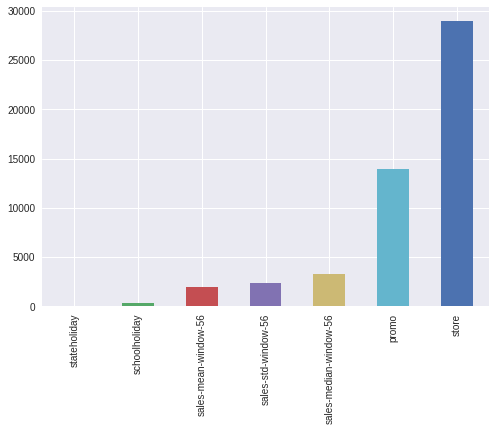

In [0]:
importances = pd.Series(model.feature_importance(importance_type="gain"), index=X_train.columns)
importances = importances.sort_values()
importances.plot(kind="bar")

In [0]:
model.feature_importance?